#Part 1


In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import time
import os
import sklearn as sci
# pytorch
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [2]:
path = ""

<class 'PIL.JpegImagePlugin.JpegImageFile'>


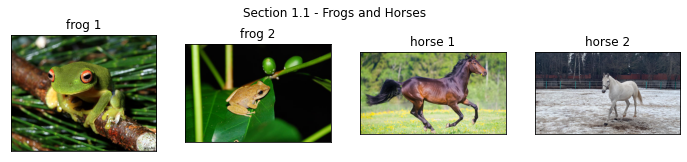

In [3]:
# Section 1.1
images = []
images.append((Image.open(f"{path}../data/frogs/frog1.jpg")))
images.append((Image.open(f"{path}../data/frogs/frog2.jpg")))
images.append((Image.open(f"{path}../data/horses/horse1.png")))
images.append((Image.open(f"{path}../data/horses/horse2.jpg")))

print(type(images[0]))

labels = ["frog 1", "frog 2", "horse 1", "horse 2"]
fig, axes = plt.subplots(1, len(images), figsize=(12,2.5))
for idx, image in enumerate(images):
    axes[idx].imshow(image)
    axes[idx].set_title(labels[idx])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

fig.suptitle('Section 1.1 - Frogs and Horses')
plt.savefig(f'{path}../output/Section 1.1 - Images From Trainset.png')

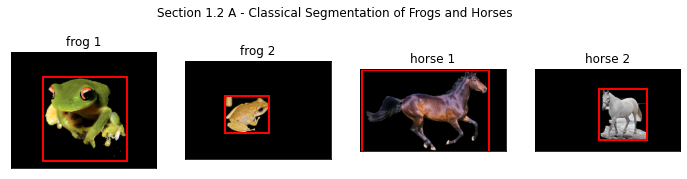

In [4]:
# Section 1.2 A

# Classic Segmentation - GrabCuts

def applyClassicSegmentation(images, rects, title, labels):

  fig, axes = plt.subplots(1, len(images), figsize=(12,3))

  bgdModel = np.zeros((1,65),np.float64)
  fgdModel = np.zeros((1,65),np.float64)

  for idx, image in enumerate(images):
    image = np.array(image)
    mask = np.zeros(image.shape[:2],np.uint8)
    cv2.grabCut(image,mask,rects[idx],bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
    mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
    image = image*mask2[:,:,np.newaxis]
    
    # plot
    axes[idx].imshow(image)
    x, y, w, h = rects[idx]
    rect = patches.Rectangle((x,y),w,h, fill=None, edgecolor='r', linewidth=2)
    axes[idx].add_patch(rect)
    axes[idx].set_title(labels[idx])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

  fig.suptitle(title)
  plt.savefig(f'{path}../output/{title}.png')

rects = [(110, 85, 290, 290), (160, 140, 180, 150), (13, 8, 895, 575), (600, 187, 450, 470)]
title = 'Section 1.2 A - Classical Segmentation of Frogs and Horses'
applyClassicSegmentation(images, rects, title, labels)

In [5]:
# Section 1.2 B

def applyDeepSegmentation(images, title, labels, savepath=True, displayImages = True):

  # Deep Segmentation - DeepLabV3 RESNET 101
  # download and load the pre-trained model
  model = torch.hub.load('pytorch/vision:v0.5.0', 'deeplabv3_resnet101', pretrained=True)
  # put in inference mode
  model.eval();

  # define device
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  # define the pre-processing steps
  # image->tensor, normalization
  preprocess = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])
  if displayImages:
    fig, axes = plt.subplots(1, len(images), figsize=(12,3))
  masked_images = []
  for idx, image in enumerate(images):
    # perform pre-processing
    input_tensor = preprocess(image)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch of size 1 as expected by the model
    # send to device
    model = model.to(device)
    input_batch = input_batch.to(device)
    
    # forward pass
    with torch.no_grad():
      output = model(input_batch)['out'][0]
    output_predictions = output.argmax(0)

    # create a color pallette, selecting a color for each class
    palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
    colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
    colors = (colors % 255).numpy().astype("uint8")

    # plot the semantic segmentation predictions of 21 classes in each color
    r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize((image.size))
    r.putpalette(colors)
    mask = (np.array(r) > 0)
    image = np.array(image) 
    image[:,:,0] = image[:,:,0] * mask
    image[:,:,1] = image[:,:,1] * mask
    image[:,:,2] = image[:,:,2] * mask
    masked_images.append(image)
    # plot
    if len(images) > 1:
      if displayImages:
        axes[idx].imshow(image)
        axes[idx].set_title(labels[idx])
        axes[idx].set_xticks([])
        axes[idx].set_yticks([])
        fig.suptitle(title)

    else:
      if displayImages:
        axes.imshow(image)
        axes.set_xticks([])
        axes.set_yticks([])
        fig.suptitle(title)


  if savepath:
    plt.savefig(f'{path}../output/{title}.png')
  return masked_images

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0


[array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]], dtype=uint8), array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0

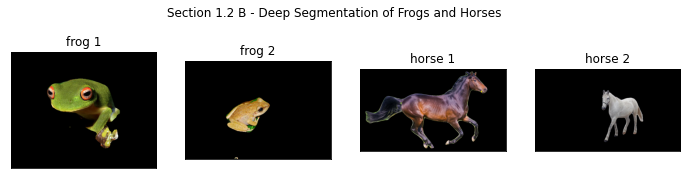

In [6]:
title = 'Section 1.2 B - Deep Segmentation of Frogs and Horses'
applyDeepSegmentation(images, title, labels)

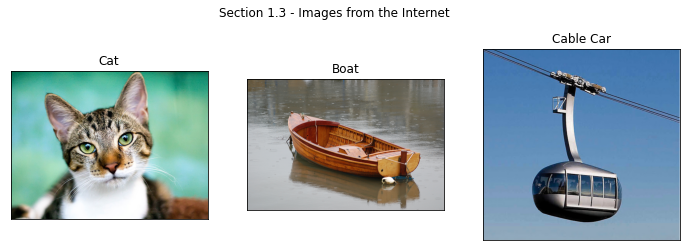

In [7]:
# Section 1.3

images = []
images.append(Image.open(f"{path}../data/my_data/cat.jpg"))
images.append(Image.open(f"{path}../data/my_data/boat.jpg"))
images.append(Image.open(f"{path}../data/my_data/cable-car.jpg"))

labels = ["Cat", "Boat", "Cable Car"]
fig, axes = plt.subplots(1, len(images), figsize=(12,4))
for idx, image in enumerate(images):
    axes[idx].imshow(image)
    axes[idx].set_title(labels[idx])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

fig.suptitle('Section 1.3 - Images from the Internet')
plt.savefig(f'{path}../output/Section 1.3 - Images From the Internet.png')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0


[array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]], dtype=uint8), array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0

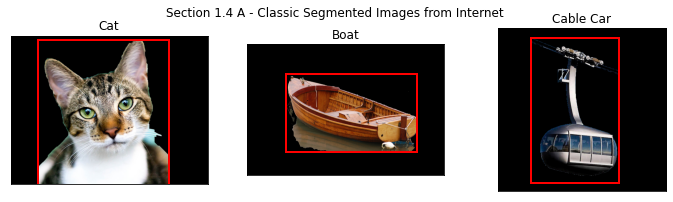

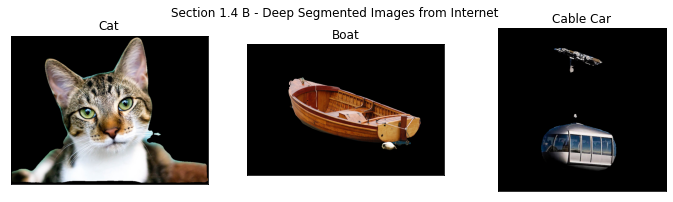

In [8]:
# Section 1.4

rects = [(125, 20, 600, 800), (600, 450, 2000, 1200), (100, 30, 270, 440)]
applyClassicSegmentation(images, rects, 'Section 1.4 A - Classic Segmented Images from Internet', labels)
applyDeepSegmentation(images, 'Section 1.4 B - Deep Segmented Images from Internet', labels)

In [9]:
# Section 1.6

# Load ImageNet class dictionary
with open(f"{path}../data/imagenet1000_clsidx_to_labels.txt") as f:
    classes = eval(f.read())

# Download and load the pre-trained model
model = torchvision.models.vgg16(pretrained=True, progress=True)
# Put in inference mode
model.eval();

# define device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


The output shape is: torch.Size([1, 1000])
The output prediction is: 291
The matching class is: lion, king of beasts, Panthera leo



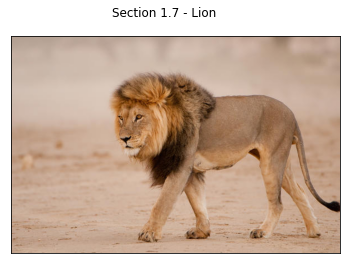

In [10]:
# Section 1.7

# Display the chosen image
Lion = Image.open(f"{path}../data/my_data/lion.jpg")

fig, axes = plt.subplots(1, 1, figsize=(12,4))
axes.imshow(Lion)
axes.set_xticks([])
axes.set_yticks([])

fig.suptitle('Section 1.7 - Lion')
plt.savefig(f'{path}../output/Section 1.7 - Lion.png')

# Feed the image to the classifier

# define the pre-processing steps
# image->tensor, normalization and resize
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Resize(size=(224, 224)),
])

# perform pre-processing
input_tensor0 = preprocess(Lion)
input_batch0 = input_tensor0.unsqueeze(0).to(device) # create a mini-batch of size 1 as expected by the model
model = model.to(device)

# forward pass
with torch.no_grad():
    output = model(input_batch0)
output_predictions = output.argmax().item()
print(f"The output shape is: {output.shape}")
print(f"The output prediction is: {output_predictions}")
print(f"The matching class is: {classes[output_predictions]}\n")

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0


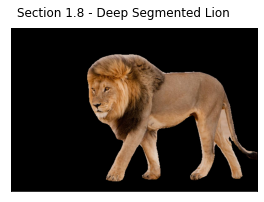

In [11]:
# Section 1.8

# Segment the goat image
masked_lion = applyDeepSegmentation([Lion], 'Section 1.8 - Deep Segmented Lion', ["Lion"])[0]

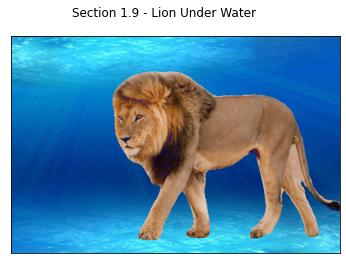

In [12]:
# Section 1.9
lion = masked_lion.copy()

# Create a mask in order to combine background image with lion
masked_lion[masked_lion != 0] = 1
masked_lion = (1 - masked_lion) 

# Load the background image
water = Image.open(f"{path}../data/my_data/water.jpg")
water = water.resize((590, 390))
lion_water = water * masked_lion + lion
fig, axes = plt.subplots(1, 1, figsize=(12,4))
axes.imshow(lion_water)
axes.set_xticks([])
axes.set_yticks([])
fig.suptitle('Section 1.9 - Lion Under Water')
plt.savefig(f'{path}../output/Section 1.9 - Lion Under Water.png')

In [13]:
# Section 1.10

# Feed the image to the classifier

# define the pre-processing steps
# image->tensor, normalization and resize
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Resize(size=(224, 224)),
])

# perform pre-processing
input_tensor0 = preprocess(lion_water)
input_batch0 = input_tensor0.unsqueeze(0).to(device) # create a mini-batch of size 1 as expected by the model
model = model.to(device)

# forward pass
with torch.no_grad():
    output = model(input_batch0)
output_predictions = output.argmax().item()
print(f"The output shape is: {output.shape}")
print(f"The output prediction is: {output_predictions}")
print(f"The matching class is: {classes[output_predictions]}\n")

The output shape is: torch.Size([1, 1000])
The output prediction is: 291
The matching class is: lion, king of beasts, Panthera leo



#Part 2

In [14]:
# Section 2.1

def video_to_image_seq(vid_path, outputList, newDim):
    vidcap = cv2.VideoCapture(vid_path)
    success, image = vidcap.read()
    image = cv2.resize(image, newDim)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(image)
    count = 0
    print("converting video to frames...")
    while success:
        outputList.append(image)
        success, image = vidcap.read()
        if success:
          image = cv2.resize(image, newDim)
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
          image = Image.fromarray(image)
        count += 1
    print("total frames: ", count)

In [15]:
# Convert video to frames
ZahiFrames = []
video_to_image_seq(f"{path}../data/my_data/Zahi_video.mkv", ZahiFrames, (960, 540))
ZahiFrames = ZahiFrames[74:225]

converting video to frames...
total frames:  371


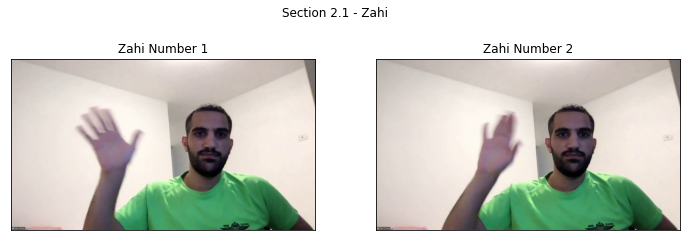

In [16]:
# Display 2 frames
ZahiImages = [ZahiFrames[122], ZahiFrames[60]]

fig, axes = plt.subplots(1, len(ZahiImages), figsize=(12,4))
for idx, image in enumerate(ZahiImages):
    axes[idx].imshow(image)
    axes[idx].set_title(f'Zahi Number {idx + 1}')
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])
fig.suptitle('Section 2.1 - Zahi')
plt.savefig(f'{path}../output/Section 2.1 - Zahi.png')

In [17]:
# Section 2.2
labels = len(ZahiFrames) * ['Zahi']
segmented_Zahi = applyDeepSegmentation(ZahiFrames, 'Section 2.2 - Deep Segmented Zahi', labels, False, False)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0


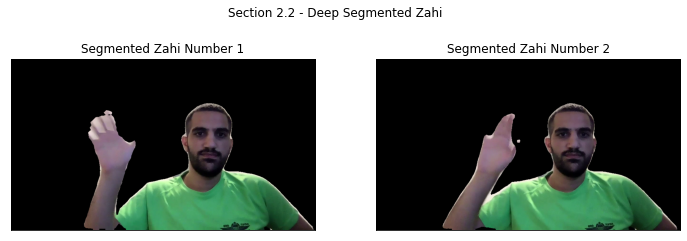

In [18]:
# Display 2 segmented frames

ZahiSegmentedImages = [segmented_Zahi[122], segmented_Zahi[60]]

fig, axes = plt.subplots(1, len(ZahiSegmentedImages), figsize=(12,4))
for idx, image in enumerate(ZahiSegmentedImages):
    axes[idx].imshow(image)
    axes[idx].set_title(f'Segmented Zahi Number {idx + 1}')
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])
fig.suptitle('Section 2.2 - Deep Segmented Zahi')
plt.savefig(f'{path}../output/Section 2.2 - Deep Segmented Zahi.png')

In [19]:
# Section 2.3

# Convert video to frames
Jet_frames = []
video_to_image_seq(f"{path}../data/jet_model.mp4", Jet_frames, (960, 540))
Jet_frames = Jet_frames[150:len(segmented_Zahi)+150]

converting video to frames...
total frames:  600


In [20]:
jet_labels = []
for i in range(len(segmented_Zahi)):
  jet_labels.append(f"jet frame {i + 1}")

# Segment the frames from the jet video
segmented_jet_frames = applyDeepSegmentation(Jet_frames[:len(segmented_Zahi)], 'Section 2.3 - Deep Segmented Jet', jet_labels, False, False)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0


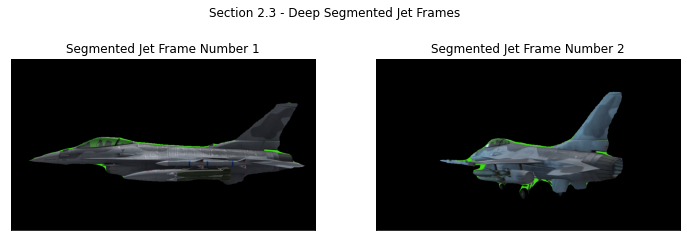

In [21]:
# Display 2 segmented frames
JetSegmentedImages = [segmented_jet_frames[0], segmented_jet_frames[60]]

fig, axes = plt.subplots(1, len(JetSegmentedImages), figsize=(12,4))
for idx, image in enumerate(JetSegmentedImages):
    axes[idx].imshow(image)
    axes[idx].set_title(f'Segmented Jet Frame Number {idx + 1}')
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])
fig.suptitle('Section 2.3 - Deep Segmented Jet Frames')
plt.savefig(f'{path}../output/Section 2.3 - Deep Segmented Jet Frames.png')

[ 57 226  12]


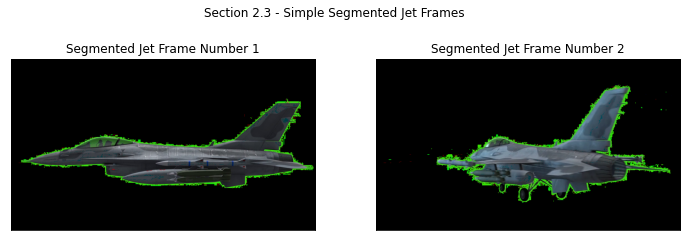

In [24]:
# Test simple segmentation method using green screen 
# Display 2 segmented frames
Jet_test = [np.array(Jet_frames[0]), np.array(Jet_frames[60])]

# get color of green background
print(Jet_test[0][10,10,:])

fig, axes = plt.subplots(1, len(Jet_test), figsize=(12,4))
for idx, image in enumerate(Jet_test):
  image[image == [57, 226, 12]] = 0
  axes[idx].imshow(image)
  axes[idx].set_title(f'Segmented Jet Frame Number {idx + 1}')
  axes[idx].set_xticks([])
  axes[idx].set_yticks([])
fig.suptitle('Section 2.3 - Simple Segmented Jet Frames')
plt.savefig(f'{path}../output/Section 2.3 - Simple Segmented Jet Frames.png')

In [25]:
# Section 2.4

# Create list of frames from segmented images and background image
galaxy = Image.open(f"{path}../data/my_data/galaxy.jpg")
galaxy = np.array(galaxy)

all_together = []
for jet, zahi in zip(segmented_jet_frames, segmented_Zahi):
  jet = cv2.resize(jet, (960, 540))
  jet = np.array(jet)
  zahi = cv2.resize(zahi, (960, 540))
  zahi = np.array(zahi)
  indices = np.where(zahi == [0,0,0])
  zahi[indices] = jet[indices]
  indices = np.where(zahi == [0, 0, 0])
  zahi[indices] = galaxy[indices]
  all_together.append(zahi)

In [26]:
def image_seq_to_video(imgs_list, output_path='./video.mp4', fps=15.0):
    output = output_path

    print("writing video...")
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Be sure to use lower case
    #out = cv2.VideoWriter(output, fourcc, fps, (1920, 1080))
    out = cv2.VideoWriter(output, fourcc, fps, (960, 540))
    # out = cv2.VideoWriter('project.avi', cv2.VideoWriter_fourcc(*'DIVX'), 15, size)

    for i in range(len(imgs_list)):
      imgs_list[i] = cv2.cvtColor(imgs_list[i], cv2.COLOR_BGR2RGB)
      out.write(imgs_list[i])
    out.release()

    print("saved video @ ", output)

writing video...
saved video @  /content/drive/MyDrive/Technion/Semester 10/046746-Algorithms and Applications in Computer Vision/Homework/HW 3/code/../output/finalVideo.mp4


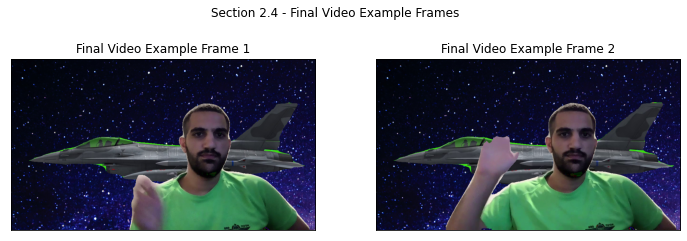

In [27]:
# Create the video
image_seq_to_video(all_together, output_path=f"{path}../output/finalVideo.mp4")

# Display 2 frames of the result
FinalResults = [cv2.cvtColor(all_together[0], cv2.COLOR_BGR2RGB), cv2.cvtColor(all_together[30], cv2.COLOR_BGR2RGB)]

fig, axes = plt.subplots(1, 2, figsize=(12,4))
for idx, image in enumerate(FinalResults):
    axes[idx].imshow(image)
    axes[idx].set_title(f'Final Video Example Frame {idx + 1}')
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])
fig.suptitle('Section 2.4 - Final Video Example Frames')
plt.savefig(f'{path}../output/Section 2.4 - Final Video Example Frames.png')